In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import cv
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error

from typing import Tuple, Dict, List
from time import time
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
from IPython.display import display

pd.set_option('display.max_columns', None)

In [3]:
!ls -l ./input

razem 165040
-rw-rw-r-- 1 jarek jarek    244438 paź  2 23:39 airports.csv
-rw-rw-r-- 1 jarek jarek       672 paź  2 23:39 carriers.csv
-rw-rw-r-- 1 jarek jarek    431598 paź  2 23:39 tail_number.csv
-rw-rw-r-- 1 jarek jarek  64738337 wrz 29 19:41 test_airline_delay.csv
-rw-rw-r-- 1 jarek jarek 103567312 wrz 29 19:29 train_airline_delay.h5


In [4]:
df_train = pd.read_hdf("./input/train_airline_delay.h5")
df_test = pd.read_csv("./input/test_airline_delay.csv")

In [5]:
df_train.head()

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay
0,0,1,943.0,17,2,947.0,1028.0,1037.0,33.0,-9.0,-4.0,13,4780,3022,45.0,50.0,MLI,ORD,139,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0
1,2,6,905.0,26,4,822.0,1026.0,932.0,117.0,54.0,43.0,7,246,1993,141.0,130.0,SAT,DEN,794,False,0,43.0,0.0,11.0,0.0,0.0,False,54.0
2,1,12,1255.0,28,5,1255.0,1342.0,1344.0,25.0,-2.0,0.0,13,4867,4955,47.0,49.0,LAX,SBA,89,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0
3,1,7,2028.0,2,1,1855.0,2136.0,1945.0,33.0,111.0,93.0,15,1505,3734,68.0,50.0,DFW,AUS,190,False,0,0.0,17.0,18.0,0.0,76.0,False,111.0
4,2,1,1358.0,7,1,1355.0,1437.0,1455.0,85.0,-18.0,3.0,1,5541,5727,99.0,120.0,SLC,LAX,590,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0


In [6]:
df_train.shape

(1077114, 28)

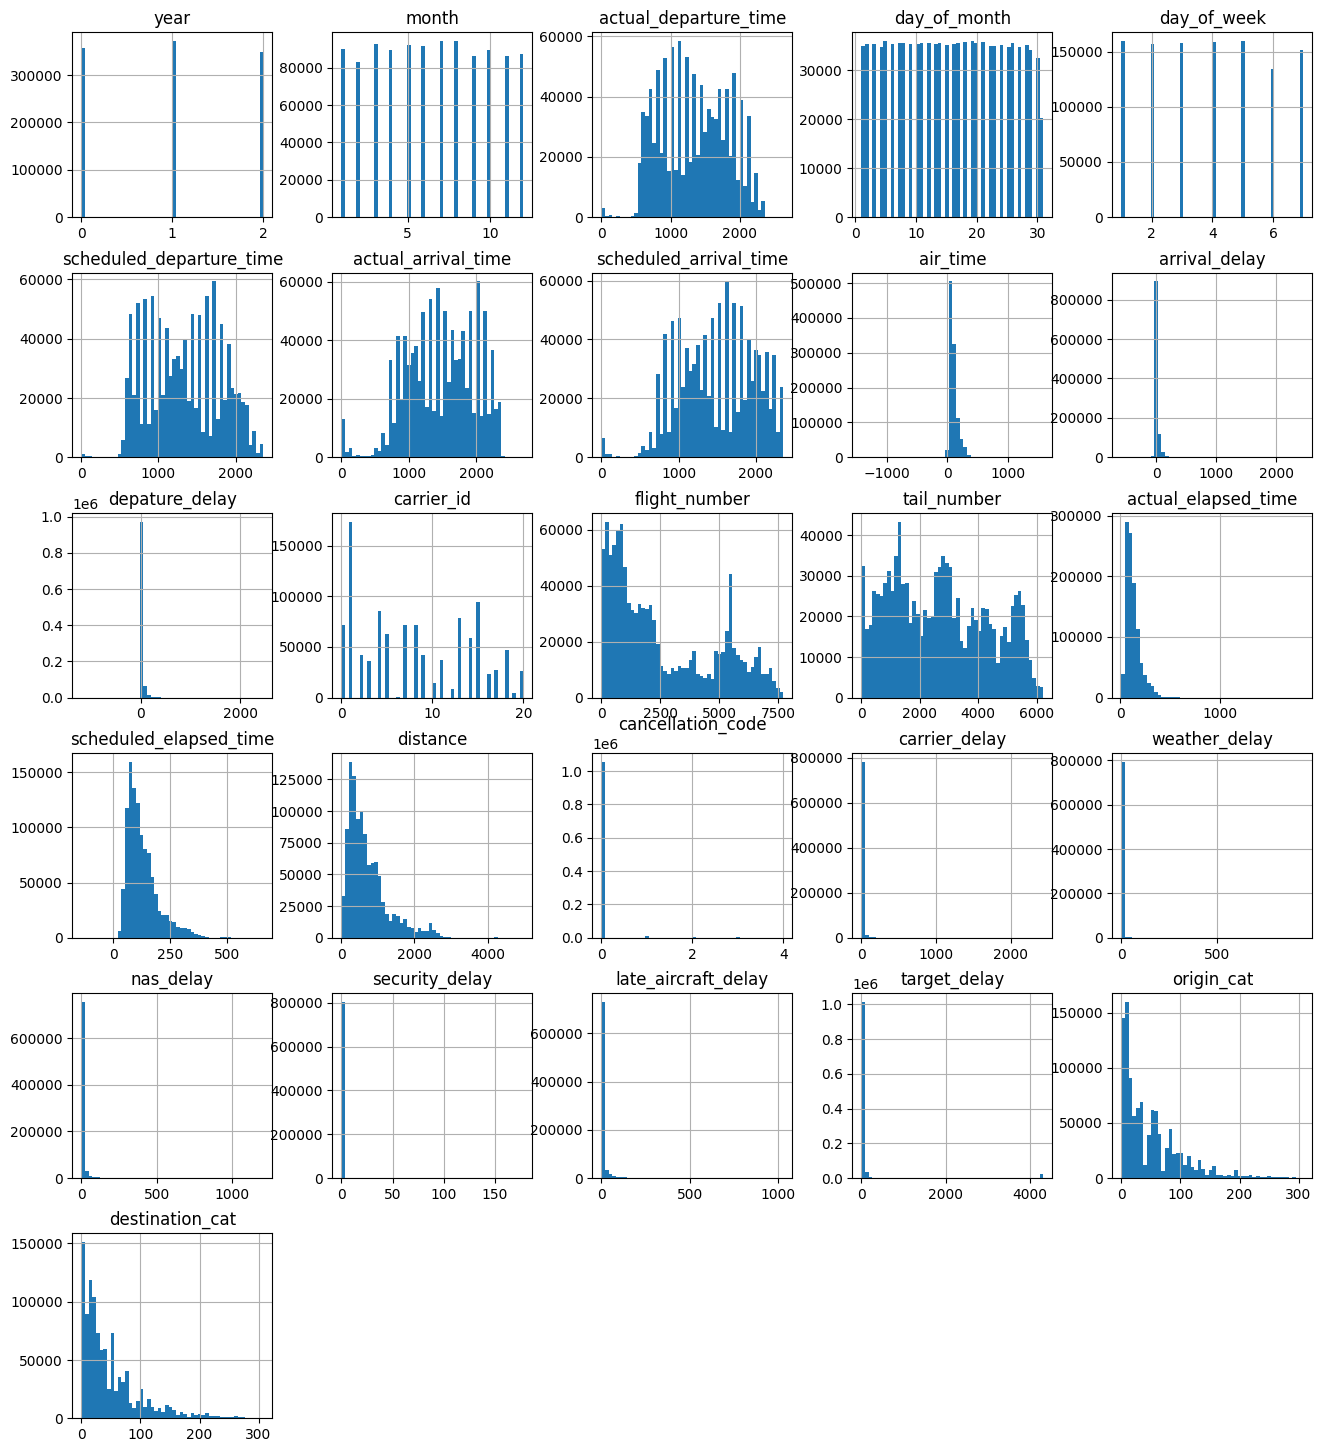

In [307]:
df_train.hist(figsize=(16,18),bins=50);

In [8]:
df_test.head()

,id,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,origin,destination,distance,target_delay
0,0,1,1,17,3,1210.0,1510.0,17,152,4311,180.0,PBI,BOS,1197,NaN
1,1,0,2,22,3,1325.0,1613.0,15,1639,3909,168.0,MIA,JFK,1090,NaN
2,2,0,10,2,1,1720.0,1850.0,13,6140,3089,90.0,PIT,LGA,335,NaN
3,3,0,4,24,1,800.0,1141.0,8,5026,2466,221.0,BOS,RSW,1249,NaN
4,4,2,1,21,1,1625.0,1840.0,1,1706,790,75.0,LAX,PHX,370,NaN


In [9]:
df_train["scheduled_elapsed_time"].fillna(value=0, inplace=True)

if "origin_cat" not in df_train.columns:
    df_train["origin_cat"] = df_train["origin"].factorize()[0]
    df_train["destination_cat"] = df_train["destination"].factorize()[0]
    
df_test["scheduled_elapsed_time"].fillna(value=0, inplace=True)

if "origin_cat" not in df_test.columns:
    df_test["origin_cat"] = df_test["origin"].factorize()[0]
    df_test["destination_cat"] = df_test["destination"].factorize()[0]


In [11]:
def two_string(x,y):
    return x + "-" + y 

df_train["connection"] = df_train.apply(lambda x: two_string(x.origin, x.destination), axis=1)
df_test["connection"] = df_test.apply(lambda x: two_string(x.origin, x.destination), axis=1)

df_train["connection_cat"] = df_train["connection"].factorize()[0]
df_test["connection_cat"] = df_test["connection"].factorize()[0]

In [225]:
df_filtered = df_train.copy()

In [226]:
# q_low = df_train["target_delay"].quantile(0.01)
# q_hi  = df_train["target_delay"].quantile(0.99)

# df_filtered = df_train[(df_train["target_delay"] < q_hi) & (df_train["target_delay"] > q_low)]
# df_filtered.target_delay.hist(bins=50)

In [228]:
myDict = df_test.dtypes.to_dict()
myDict

{'id': dtype('int64'),
 'year': dtype('int64'),
 'month': dtype('int64'),
 'day_of_month': dtype('int64'),
 'day_of_week': dtype('int64'),
 'scheduled_departure_time': dtype('float64'),
 'scheduled_arrival_time': dtype('float64'),
 'carrier_id': dtype('int64'),
 'flight_number': dtype('int64'),
 'tail_number': dtype('int64'),
 'scheduled_elapsed_time': dtype('float64'),
 'origin': dtype('O'),
 'destination': dtype('O'),
 'distance': dtype('int64'),
 'target_delay': dtype('float64'),
 'origin_cat': dtype('int64'),
 'destination_cat': dtype('int64')}

In [229]:
desired_values = ['int64','float64']

f = []
for k, v in myDict.items():
    if v in desired_values:
        f.append(k)

print(f)

['id', 'year', 'month', 'day_of_month', 'day_of_week', 'scheduled_departure_time', 'scheduled_arrival_time', 'carrier_id', 'flight_number', 'tail_number', 'scheduled_elapsed_time', 'distance', 'target_delay', 'origin_cat', 'destination_cat']


In [230]:
black_list = ['id']

In [231]:
feats = [n for n in f if n not in black_list ]
feats

['year',
 'month',
 'day_of_month',
 'day_of_week',
 'scheduled_departure_time',
 'scheduled_arrival_time',
 'carrier_id',
 'flight_number',
 'tail_number',
 'scheduled_elapsed_time',
 'distance',
 'target_delay',
 'origin_cat',
 'destination_cat']

In [232]:
df = df_filtered[feats].copy()
df.describe()

,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,distance,target_delay,origin_cat,destination_cat
count,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1077114.0,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06
mean,9.938029e-01,6.484457e+00,1.572170e+01,3.935226e+00,1.329981e+03,1.495584e+03,8.055353e+00,2.586279e+03,2.700669e+03,NaN,7.232282e+02,9.807208e+01,4.976698e+01,4.875866e+01
std,8.093119e-01,3.419676e+00,8.788712e+00,1.991249e+00,4.640490e+02,4.810844e+02,6.053063e+00,2.195860e+03,1.667933e+03,NaN,5.647693e+02,5.951953e+02,5.010842e+01,5.052040e+01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-141.0,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,9.300000e+02,1.115000e+03,2.000000e+00,7.400000e+02,1.256000e+03,78.0,3.200000e+02,0.000000e+00,1.200000e+01,1.400000e+01
50%,1.000000e+00,6.000000e+00,1.600000e+01,4.000000e+00,1.321000e+03,1.518000e+03,7.000000e+00,1.798000e+03,2.631000e+03,110.0,5.740000e+02,0.000000e+00,3.300000e+01,3.100000e+01
75%,2.000000e+00,9.000000e+00,2.300000e+01,6.000000e+00,1.720000e+03,1.907000e+03,1.400000e+01,4.705000e+03,4.058000e+03,157.0,9.500000e+02,1.400000e+01,7.400000e+01,6.700000e+01
max,2.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.359000e+03,2.000000e+01,7.713000e+03,6.225000e+03,660.0,4.962000e+03,4.320000e+03,3.080000e+02,3.080000e+02


In [259]:
X = df.drop('target_delay', axis=1)
y = df['target_delay']

In [260]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [262]:
# Create a tree explainer
import shap

xgb_explainer = shap.TreeExplainer(model, X_train, feature_names=X_train.columns.tolist())

CPU times: user 261 ms, sys: 8.57 ms, total: 269 ms
Wall time: 267 ms


In [263]:
%%time

# Shap values with tree explainer
shap_values = xgb_explainer.shap_values(X_train, y_train)

100%|===================| 721513/721666 [14:36<00:00]        

CPU times: user 14min 39s, sys: 1.97 s, total: 14min 40s
Wall time: 14min 38s


In [264]:
%%time

# Shap values with XGBoost core moedl
booster_xgb = model.get_booster()

shap_values_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train),pred_contribs=True)

CPU times: user 2.55 s, sys: 2.32 s, total: 4.88 s
Wall time: 4.36 s


In [266]:
shap_values_xgb.shape

(721666, 14)

In [267]:
shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,distance,origin_cat,destination_cat
0,-0.003818,0.028978,0.016205,0.010327,0.019285,0.039074,0.006624,0.092548,0.013238,0.040628,-0.061677,0.051638,0.049304
1,-0.008953,0.016159,0.006035,0.003588,0.042970,0.011723,-0.044510,0.017717,0.004232,0.024883,-0.050234,0.038052,0.035708
2,-0.007595,0.014644,0.014312,0.003863,0.051199,0.020872,0.006130,0.042066,0.002085,0.036840,-0.044687,0.053366,0.045184
3,-0.006922,0.022421,0.005541,-0.001579,-0.005061,0.041141,-0.045470,0.056682,0.010450,0.018523,-0.065729,0.044986,0.013719
4,-0.002683,0.024259,0.011292,0.009513,0.009603,0.029062,-0.050249,0.064081,0.014006,0.028045,-0.067316,0.036672,0.038752


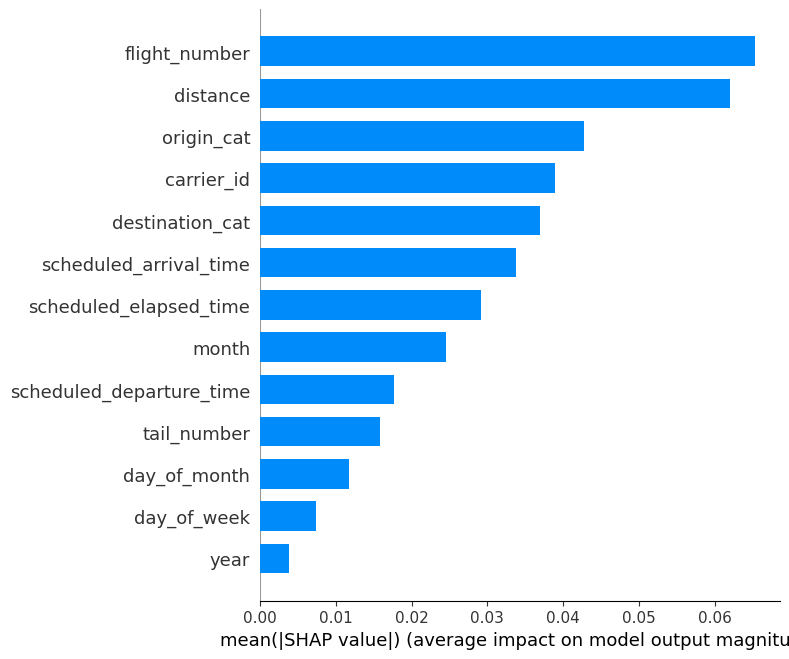

In [268]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns, plot_type="bar")

In [273]:
import eli5
from IPython.display import display

eli5.explain_weights(model, top=50)

Weight,Feature
0.7254,tail_number
0.1599,carrier_id
0.0337,distance
0.0302,year
0.0092,scheduled_elapsed_time
0.0063,month
0.0055,day_of_week
0.0055,destination_cat
0.0054,day_of_month
0.0053,origin_cat


In [274]:
pd.DataFrame(shap_values_xgb, columns=X_train.columns)["flight_number"].abs().mean()

0.0655479

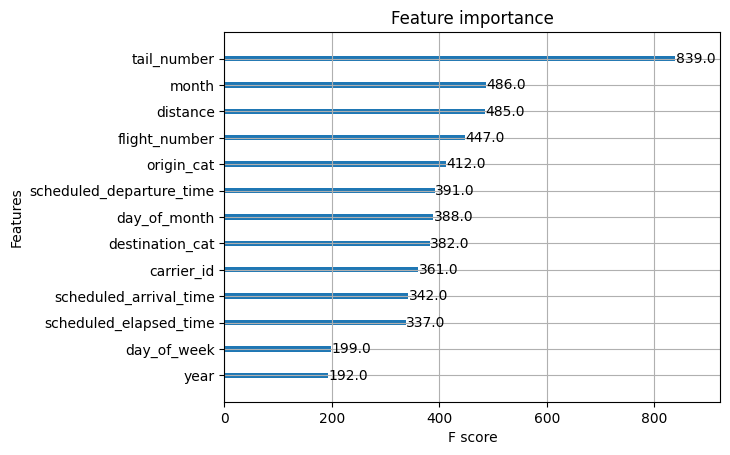

In [275]:
xgb.plot_importance(booster_xgb);

In [287]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorspacious import cspace_converter

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

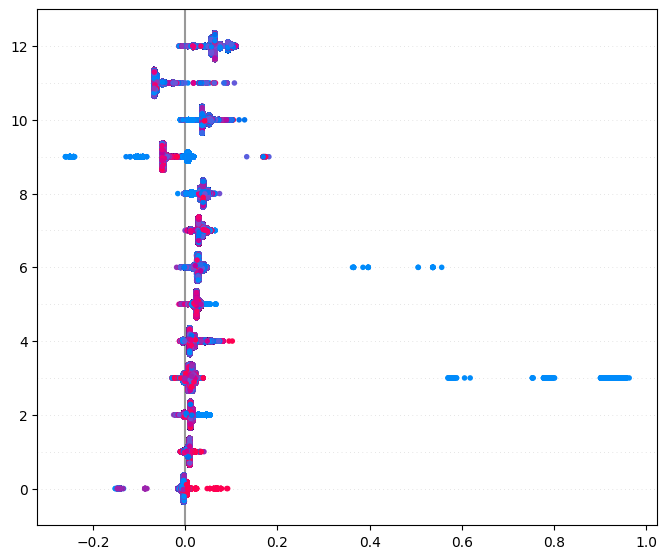

In [288]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns);

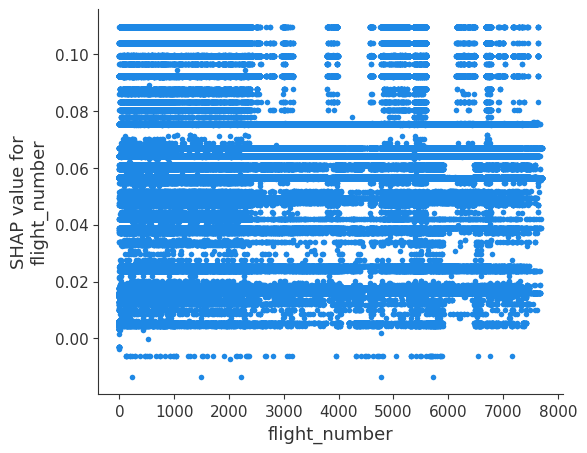

In [291]:
shap.dependence_plot("flight_number", shap_values_xgb, X_train, interaction_index=None)

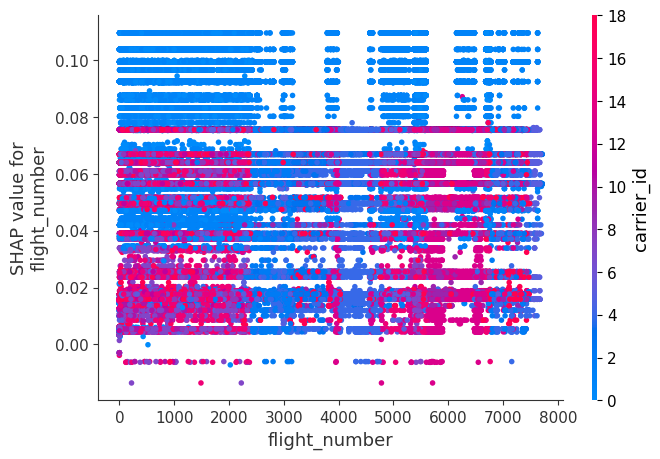

In [292]:
shap.dependence_plot("flight_number", shap_values_xgb, X_train, interaction_index="auto");

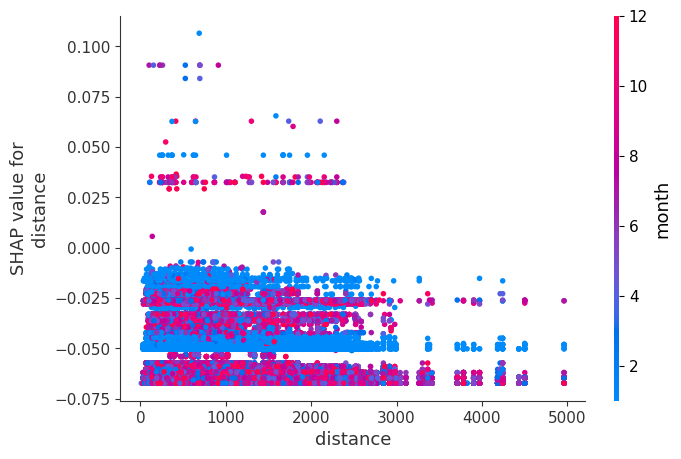

In [293]:
shap.dependence_plot("distance", shap_values_xgb, X_train, interaction_index="auto");

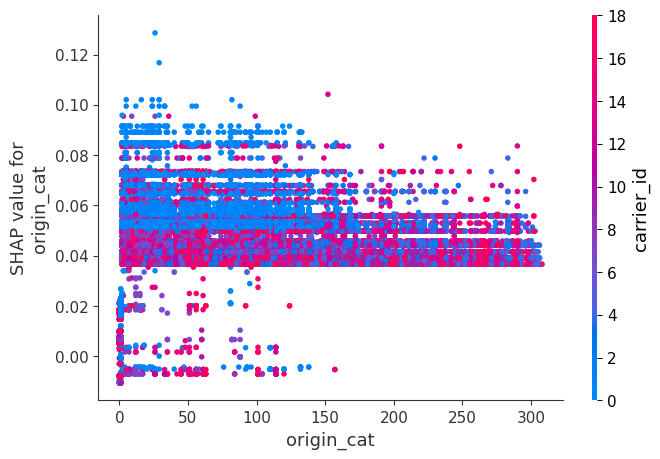

In [294]:
shap.dependence_plot("origin_cat", shap_values_xgb, X_train, interaction_index="auto");

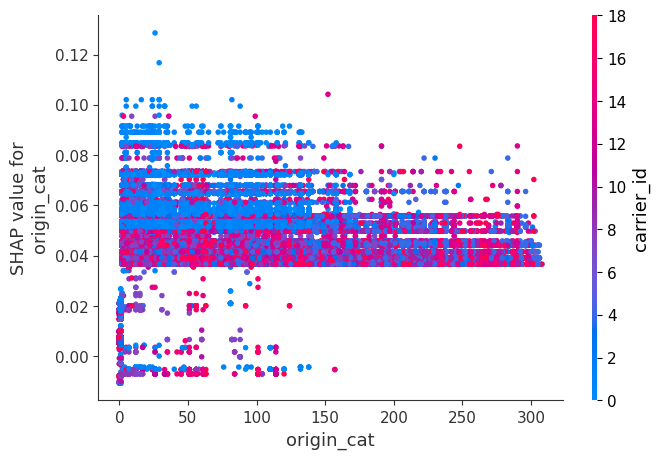

In [295]:
shap.dependence_plot("origin_cat", shap_values_xgb, X_train, feature_names=X_train.columns);

In [ ]:
# interactions = xgb_explainer.shap_interaction_values(X_train, y_train)

In [296]:
%%time

# SHAP interactions with XGB
interactions_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train), pred_interactions=True)

CPU times: user 17.9 s, sys: 21.7 s, total: 39.6 s
Wall time: 39.1 s


In [297]:
interactions_xgb.shape

(721666, 14, 14)

In [299]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]


top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(X_train.columns, interactions_xgb, 10)

In [300]:
top_10_inter_feats

('distance-scheduled_elapsed_time',
 'flight_number-scheduled_departure_time',
 'origin_cat-flight_number',
 'origin_cat-scheduled_arrival_time',
 'scheduled_arrival_time-scheduled_departure_time',
 'flight_number-carrier_id',
 'flight_number-month',
 'distance-day_of_month',
 'flight_number-day_of_month',
 'distance-flight_number')

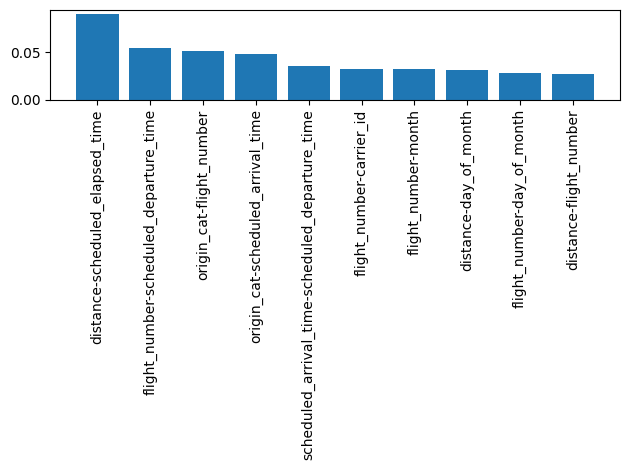

In [301]:
def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();
    

top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

In [305]:
random_idx = np.random.randint(len(X_train))
random_idx

348615

In [303]:
%%time

# Recalculate SHAP values
shap_explainer_values = xgb_explainer(X_train, y_train)

100%|===================| 721477/721666 [14:08<00:00]        

CPU times: user 14min 10s, sys: 2.4 s, total: 14min 13s
Wall time: 14min 9s


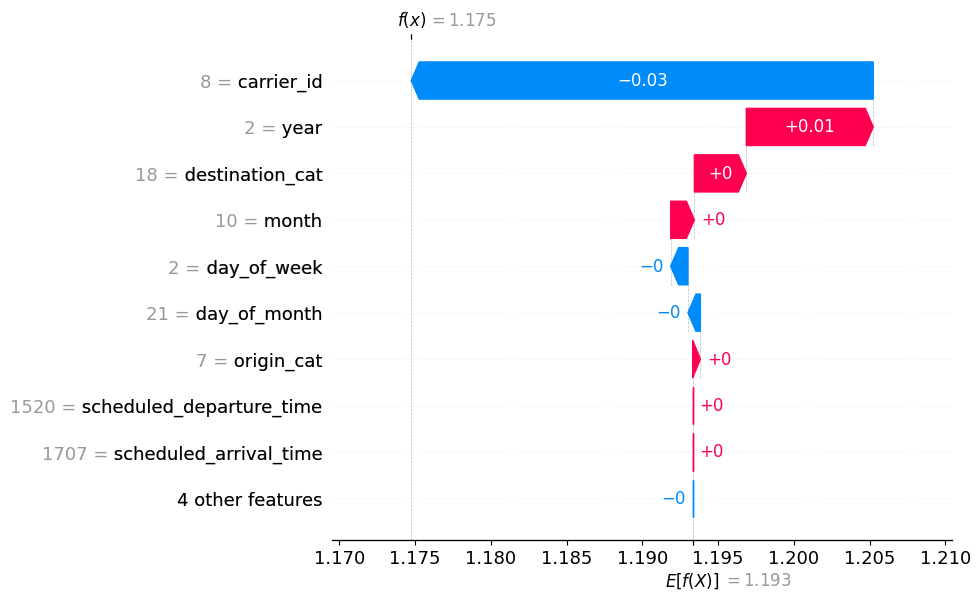

In [304]:
shap.waterfall_plot(shap_explainer_values[241705])

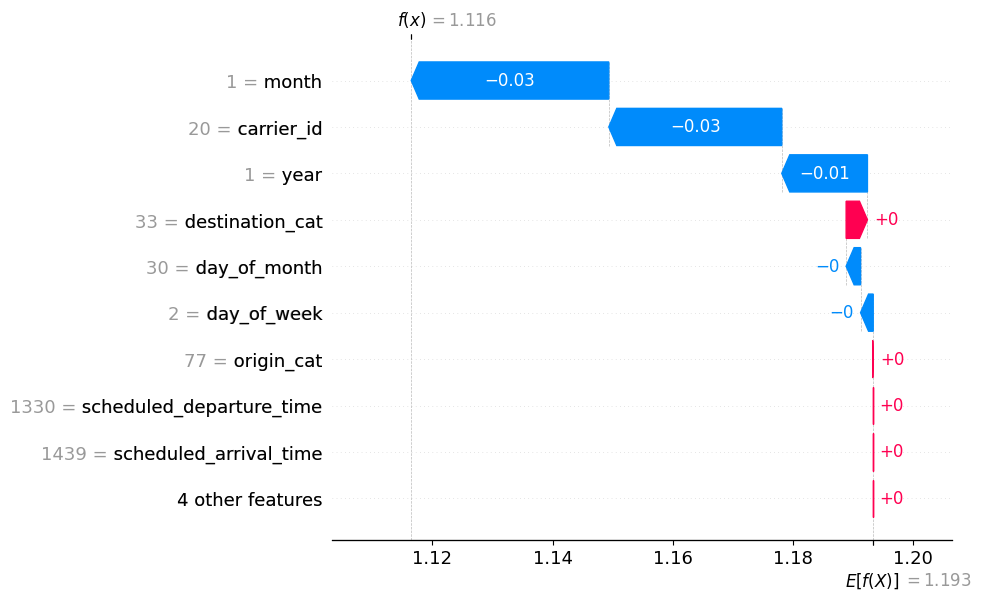

In [306]:
shap.waterfall_plot(shap_explainer_values[348615])

In [234]:
scaler = MinMaxScaler(feature_range=(1,2))
scaler.fit(X)
X_tran = scaler.transform(X)

In [235]:
# define a method to scale data, looping thru the columns, and passing a scaler
scaler = MinMaxScaler(feature_range=(1,2))

def scale_data(data, columns, scaler):
    for col in columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [236]:
y_tran = scale_data(df, ['target_delay'], scaler)['target_delay'].values
y_tran

array([1.        , 1.0125    , 1.        , ..., 1.        , 1.00300926,
       1.        ])

In [237]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_tran, y_tran, test_size=0.33, random_state=42)

In [238]:
X_train.shape, X_valid.shape

((721666, 13), (355448, 13))

In [247]:
model = xgb.XGBRegressor(n_estimators=500, tree_method="gpu_hist").fit(X_train, y_train)

In [248]:
y_pred = model.predict(X_valid)

In [249]:
from sklearn.metrics import mean_squared_error

rmsle = mean_squared_log_error(y_valid, y_pred, squared=False)
rmsle

0.03233381851685292

In [255]:
model = xgb.XGBRegressor(max_depth=6, n_estimators=100, learning_rate=0.3, objective="reg:squaredlogerror", random_state=0, tree_method='gpu_hist')
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

rmsle = mean_squared_log_error(y_valid, y_pred, squared=False)
rmsle

0.03153933291944519

In [16]:
df_tail_delay =  df_filtered[["tail_number", "target_delay"]].groupby("tail_number").agg(
    mean_tail_delay=("target_delay", "mean"),
    median_tail_delay=("target_delay", "median"),
    count_tail_delay=("target_delay", "count"),
    count_zeros_tail_delay=("target_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_tail_delay=("target_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

if "mean_tail_delay" not in df_train:
    df_filtered = pd.merge(df_filtered, df_tail_delay, on="tail_number", how="left")
    
if "mean_tail_delay" not in df_test:
    df_test = pd.merge(df_test, df_tail_delay, on="tail_number", how="left")

In [17]:
df_destination_delay =  df_filtered[["destination", "target_delay"]].groupby("destination").agg(
    mean_destination_delay=("target_delay", "mean"),
    median_destination_delay=("target_delay", "median"),
    count_destination_delay=("target_delay", "count"),
    count_zeros_destination_delay=("target_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_destination_delay=("target_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

if "mean_destination_delay" not in df_train:
    df_filtered = pd.merge(df_filtered, df_destination_delay, on="destination", how="left")
    
if "mean_destination_delay" not in df_test:
    df_test = pd.merge(df_test, df_destination_delay, on="destination", how="left")

In [18]:
df_connection_delay =  df_filtered[["connection", "target_delay"]].groupby("connection").agg(
    mean_connection_delay=("target_delay", "mean"),
    median_connection_delay=("target_delay", "median"),
    count_connection_delay=("target_delay", "count"),
    count_zeros_connection_delay=("target_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_connection_delay=("target_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

if "mean_connection_delay" not in df_train:
    df_filtered = pd.merge(df_filtered, df_connection_delay, on="connection", how="left")
    
if "mean_connection_delay" not in df_test:
    df_test = pd.merge(df_test, df_connection_delay, on="connection", how="left")

In [19]:
df_distance_delay =  df_filtered[["distance", "target_delay"]].groupby("distance").agg(
    mean_distance_delay=("target_delay", "mean"),
    median_distance_delay=("target_delay", "median"),
    count_distance_delay=("target_delay", "count"),
    count_zeros_distance_delay=("target_delay", lambda vals: len([x for x in vals if x == 0]) ),
    prob_zeros_distance_delay=("target_delay", lambda vals: np.mean([x == 0 for x in vals]) ),
).reset_index()

if "mean_distance_delay" not in df_train:
    df_filtered = pd.merge(df_filtered, df_distance_delay, on="distance", how="left")
    
if "mean_distance_delay" not in df_test:
    df_test = pd.merge(df_test, df_distance_delay, on="distance", how="left")

In [20]:
df_train["scheduled_elapsed_time"] * df_train["distance"]

0            6950.0
1          103220.0
2            4361.0
3            9500.0
4           70800.0
             ...   
1077109     44002.0
1077110     15265.0
1077111      7296.0
1077112     24726.0
1077113    254085.0
Length: 1077114, dtype: float64

In [22]:
df_filtered.head()

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay,origin_cat,destination_cat,connection,connection_cat,mean_tail_delay,median_tail_delay,count_tail_delay,count_zeros_tail_delay,prob_zeros_tail_delay,mean_destination_delay,median_destination_delay,count_destination_delay,count_zeros_destination_delay,prob_zeros_destination_delay,mean_connection_delay,median_connection_delay,count_connection_delay,count_zeros_connection_delay,prob_zeros_connection_delay,mean_distance_delay,median_distance_delay,count_distance_delay,count_zeros_distance_delay,prob_zeros_distance_delay
0,0,1,943.0,17,2,947.0,1028.0,1037.0,33.0,-9.0,-4.0,13,4780,3022,45.0,50.0,MLI,ORD,139,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0,MLI-ORD,0,21.252708,1.0,277,137,0.494585,209.686874,1.0,54783,27215,0.496778,306.014742,0.0,407,223,0.547912,307.603513,0.0,797,403,0.505646
1,2,6,905.0,26,4,822.0,1026.0,932.0,117.0,54.0,43.0,7,246,1993,141.0,130.0,SAT,DEN,794,False,0,43.0,0.0,11.0,0.0,0.0,False,54.0,1,1,SAT-DEN,1,23.796209,0.0,211,109,0.516588,83.900646,0.0,35600,19513,0.548118,32.673973,0.0,365,213,0.583562,44.023838,0.0,839,432,0.514899
2,1,12,1255.0,28,5,1255.0,1342.0,1344.0,25.0,-2.0,0.0,13,4867,4955,47.0,49.0,LAX,SBA,89,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,2,2,LAX-SBA,2,8.588542,0.0,192,122,0.635417,82.104948,0.0,2001,1192,0.595702,27.838838,0.0,757,512,0.676354,84.225397,0.0,2205,1412,0.640363
3,1,7,2028.0,2,1,1855.0,2136.0,1945.0,33.0,111.0,93.0,15,1505,3734,68.0,50.0,DFW,AUS,190,False,0,0.0,17.0,18.0,0.0,76.0,False,111.0,3,3,DFW-AUS,3,15.091837,0.0,196,103,0.525510,81.960407,0.0,7476,4099,0.548288,133.646283,0.0,834,419,0.502398,163.449346,0.0,3060,1607,0.525163
4,2,1,1358.0,7,1,1355.0,1437.0,1455.0,85.0,-18.0,3.0,1,5541,5727,99.0,120.0,SLC,LAX,590,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0,4,4,SLC-LAX,4,12.219512,0.0,164,94,0.573171,75.654671,0.0,34402,18170,0.528167,43.729630,0.0,810,424,0.523457,79.781650,0.0,3902,2001,0.512814


In [23]:
df_test.head()

,id,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,origin,destination,distance,target_delay,origin_cat,destination_cat,connection,connection_cat,mean_tail_delay,median_tail_delay,count_tail_delay,count_zeros_tail_delay,prob_zeros_tail_delay,mean_destination_delay,median_destination_delay,count_destination_delay,count_zeros_destination_delay,prob_zeros_destination_delay,mean_connection_delay,median_connection_delay,count_connection_delay,count_zeros_connection_delay,prob_zeros_connection_delay,mean_distance_delay,median_distance_delay,count_distance_delay,count_zeros_distance_delay,prob_zeros_distance_delay
0,0,1,1,17,3,1210.0,1510.0,17,152,4311,180.0,PBI,BOS,1197,NaN,0,0,PBI-BOS,0,35.027473,0.0,182.0,110.0,0.604396,147.528098,0.0,18809,9920,0.527407,85.864000,0.0,250.0,137.0,0.548000,65.684630,2.0,1633.0,748.0,0.458053
1,1,0,2,22,3,1325.0,1613.0,15,1639,3909,168.0,MIA,JFK,1090,NaN,1,1,MIA-JFK,1,29.507463,12.0,67.0,23.0,0.343284,133.143132,2.0,17641,8403,0.476334,65.659701,5.0,335.0,134.0,0.400000,61.321495,2.0,1070.0,513.0,0.479439
2,2,0,10,2,1,1720.0,1850.0,13,6140,3089,90.0,PIT,LGA,335,NaN,2,2,PIT-LGA,2,15.659292,0.0,226.0,131.0,0.579646,221.697504,4.0,18268,7924,0.433764,146.552727,5.0,275.0,111.0,0.403636,80.516458,0.0,1276.0,679.0,0.532132
3,3,0,4,24,1,800.0,1141.0,8,5026,2466,221.0,BOS,RSW,1249,NaN,3,3,BOS-RSW,3,12.464286,0.0,140.0,74.0,0.528571,45.721506,0.0,4036,2217,0.549306,85.244813,0.0,241.0,126.0,0.522822,83.897203,0.0,1430.0,747.0,0.522378
4,4,2,1,21,1,1625.0,1840.0,1,1706,790,75.0,LAX,PHX,370,NaN,4,4,LAX-PHX,4,11.009464,0.0,317.0,159.0,0.501577,71.149943,0.0,31452,17693,0.562540,109.983702,0.0,1718.0,888.0,0.516880,125.109834,0.0,5308.0,2789.0,0.525433


In [24]:
feats = ['year',
         'month',
         'day_of_month',
         'day_of_week',
         'scheduled_departure_time',
         'scheduled_arrival_time',
         'carrier_id',
         'flight_number',
         'tail_number',
         'scheduled_elapsed_time',
         'distance',
         'origin_cat',
         'destination_cat',
         'connection_cat',
         'mean_tail_delay',
         'median_tail_delay',
         'count_tail_delay',
         'count_zeros_tail_delay',
         'prob_zeros_tail_delay',
         'mean_destination_delay',
         'median_destination_delay',
         'count_destination_delay',
         'count_zeros_destination_delay',
         'prob_zeros_destination_delay',
         'mean_connection_delay',
         'median_connection_delay',
         'count_connection_delay',
         'count_zeros_connection_delay',
         'prob_zeros_connection_delay',
         'mean_distance_delay',
         'median_distance_delay',
         'count_distance_delay',
         'count_zeros_distance_delay',
         'prob_zeros_distance_delay']

In [25]:
df_filtered[feats].isna().sum()

year                             0
month                            0
day_of_month                     0
day_of_week                      0
scheduled_departure_time         0
scheduled_arrival_time           0
carrier_id                       0
flight_number                    0
tail_number                      0
scheduled_elapsed_time           0
distance                         0
origin_cat                       0
destination_cat                  0
connection_cat                   0
mean_tail_delay                  0
median_tail_delay                0
count_tail_delay                 0
count_zeros_tail_delay           0
prob_zeros_tail_delay            0
mean_destination_delay           0
median_destination_delay         0
count_destination_delay          0
count_zeros_destination_delay    0
prob_zeros_destination_delay     0
mean_connection_delay            0
median_connection_delay          0
count_connection_delay           0
count_zeros_connection_delay     0
prob_zeros_connectio

In [26]:
df_test[feats].isna().sum()

year                               0
month                              0
day_of_month                       0
day_of_week                        0
scheduled_departure_time           0
scheduled_arrival_time             0
carrier_id                         0
flight_number                      0
tail_number                        0
scheduled_elapsed_time             0
distance                           0
origin_cat                         0
destination_cat                    0
connection_cat                     0
mean_tail_delay                   31
median_tail_delay                 31
count_tail_delay                  31
count_zeros_tail_delay            31
prob_zeros_tail_delay             31
mean_destination_delay             0
median_destination_delay           0
count_destination_delay            0
count_zeros_destination_delay      0
prob_zeros_destination_delay       0
mean_connection_delay            100
median_connection_delay          100
count_connection_delay           100
c

## Airports

In [27]:
df_airports = pd.read_csv("./input/airports.csv")
df_airports

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944
...,...,...,...,...,...,...,...
3371,ZEF,Elkin Municipal,Elkin,NC,USA,36.280024,-80.786069
3372,ZER,Schuylkill Cty/Joe Zerbey,Pottsville,PA,USA,40.706449,-76.373147
3373,ZPH,Zephyrhills Municipal,Zephyrhills,FL,USA,28.228065,-82.155916
3374,ZUN,Black Rock,Zuni,NM,USA,35.083227,-108.791777


## Carriers

In [28]:
df_carriers = pd.read_csv("./input/carriers.csv")
df_carriers

,code,description,id
0,9E,Pinnacle Airlines Inc.,20
1,AA,American Airlines Inc.,15
2,AQ,Aloha Airlines Inc.,19
3,AS,Alaska Airlines Inc.,16
4,B6,JetBlue Airways,17
5,CO,Continental Air Lines Inc.,18
6,DL,Delta Air Lines Inc.,8
7,EV,Atlantic Southeast Airlines,9
8,F9,Frontier Airlines Inc.,10
9,FL,AirTran Airways Corporation,11


## Tail numbers

In [29]:
df_tail_nr = pd.read_csv("./input/tail_number.csv")
df_tail_nr

,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3901.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3893.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4066.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3902.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3890.0
...,...,...,...,...,...,...,...,...,...
5024,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992,2243.0
5025,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002,2811.0
5026,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992,2357.0
5027,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998,1133.0


In [30]:
df_tail_nr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           4480 non-null   object 
 1   manufacturer   4480 non-null   object 
 2   issue_date     4480 non-null   object 
 3   model          4480 non-null   object 
 4   status         4480 non-null   object 
 5   aircraft_type  4480 non-null   object 
 6   engine_type    4480 non-null   object 
 7   year           4480 non-null   object 
 8   id             4880 non-null   float64
dtypes: float64(1), object(8)
memory usage: 353.7+ KB


In [31]:
df_tail_new =  df_tail_nr[df_tail_nr["issue_date"].notna()]
df_tail_new.head()

,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,id
34,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004,1386.0
35,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,167.0
36,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986,4592.0
37,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999,5647.0
38,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,4741.0


In [32]:
df_tail_new2 = df_tail_new[ df_tail_new["id"].notna() ]
df_tail_new2.shape[0]

4477

In [33]:
df_tail = df_tail_new2[ df_tail_new2["issue_date"] != "None" ]
df_tail

,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,id
34,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004,1386.0
35,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,167.0
36,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986,4592.0
37,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999,5647.0
38,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,4741.0
...,...,...,...,...,...,...,...,...,...
5024,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992,2243.0
5025,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002,2811.0
5026,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992,2357.0
5027,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998,1133.0


In [34]:
from datetime import datetime
import datetime as dt

In [35]:
date_str = '02/13/2004'

date_object = datetime.strptime(date_str, '%m/%d/%Y').date()
date_object

datetime.date(2004, 2, 13)

In [36]:
df_tail["date"] = df_tail["issue_date"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').date() )

In [37]:
df_tail["year_tail"] = df_tail["date"].apply(lambda x: x.year)
df_tail["month_tail"] = df_tail["date"].apply(lambda x: x.month)
df_tail["day_tail"] = df_tail["date"].apply(lambda x: x.day)

In [38]:
df_tail

,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,id,date,year_tail,month_tail,day_tail
34,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004,1386.0,2004-02-13,2004,2,13
35,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,167.0,1999-05-26,1999,5,26
36,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986,4592.0,1997-07-01,1997,7,1
37,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999,5647.0,1999-06-18,1999,6,18
38,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,4741.0,1998-01-26,1998,1,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992,2243.0,1992-03-11,1992,3,11
5025,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002,2811.0,2003-01-23,2003,1,23
5026,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992,2357.0,1992-04-02,1992,4,2
5027,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998,1133.0,2008-07-09,2008,7,9


In [39]:
df_tail.rename(columns = {'id':'tail_number'}, inplace = True)

In [40]:
df_tail["type_cat"] = df_tail["type"].factorize()[0]
df_tail["manufacturer_cat"] = df_tail["manufacturer"].factorize()[0]
df_tail["model_cat"] = df_tail["model"].factorize()[0]
df_tail["satus_cat"] = df_tail["status"].factorize()[0]
df_tail["aircraft_type_cat"] = df_tail["aircraft_type"].factorize()[0]
df_tail["engine_type_cat"] = df_tail["engine_type"].factorize()[0]
df_tail.head()

,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,tail_number,date,year_tail,month_tail,day_tail,type_cat,manufacturer_cat,model_cat,satus_cat,aircraft_type_cat,engine_type_cat
34,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004,1386.0,2004-02-13,2004,2,13,0,0,0,0,0,0
35,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,167.0,1999-05-26,1999,5,26,0,1,1,0,0,0
36,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986,4592.0,1997-07-01,1997,7,1,0,2,2,0,0,1
37,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999,5647.0,1999-06-18,1999,6,18,0,1,1,0,0,0
38,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,4741.0,1998-01-26,1998,1,26,0,2,3,0,0,0


In [41]:
[n for n in df_tail.columns if "_cat" in n]


['type_cat',
 'manufacturer_cat',
 'model_cat',
 'satus_cat',
 'aircraft_type_cat',
 'engine_type_cat']

In [42]:
tail_feats = ['tail_number', 'type_cat', 'manufacturer_cat', 'model_cat', 'satus_cat', 'aircraft_type_cat', 'engine_type_cat', 'year', 'month', 'day']

In [43]:
df_tail = df_tail[tail_feats].copy()
df_tail

KeyError: "['month', 'day'] not in index"

In [161]:
if "manufacturer_cat" not in df_filtered:
    df_filtered = pd.merge(df_filtered, df_tail, on="tail_number", how="left")
    
if "manufacturer_cat" not in df_test:
    df_test = pd.merge(df_test, df_tail, on="tail_number", how="left")

In [162]:
df_filtered.head()

,year_x,month_x,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay,origin_cat,destination_cat,connection,connection_cat,mean_tail_delay,median_tail_delay,count_tail_delay,count_zeros_tail_delay,prob_zeros_tail_delay,mean_destination_delay,median_destination_delay,count_destination_delay,count_zeros_destination_delay,prob_zeros_destination_delay,mean_connection_delay,median_connection_delay,count_connection_delay,count_zeros_connection_delay,prob_zeros_connection_delay,type_cat,manufacturer_cat,model_cat,satus_cat,aircraft_type_cat,engine_type_cat,year_y,month_y,day
0,0,1,943.0,17,2,947.0,1028.0,1037.0,33.0,-9.0,-4.0,13,4780,3022,45.0,50.0,MLI,ORD,139,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0,MLI-ORD,0,21.252708,1.0,277,137,0.494585,209.686874,1.0,54783,27215,0.496778,306.014742,0.0,407,223,0.547912,0.0,0.0,4.0,0.0,0.0,0.0,2004.0,6.0,8.0
1,2,6,905.0,26,4,822.0,1026.0,932.0,117.0,54.0,43.0,7,246,1993,141.0,130.0,SAT,DEN,794,False,0,43.0,0.0,11.0,0.0,0.0,False,54.0,1,1,SAT-DEN,1,23.796209,0.0,211,109,0.516588,83.900646,0.0,35600,19513,0.548118,32.673973,0.0,365,213,0.583562,0.0,2.0,27.0,0.0,0.0,0.0,1987.0,2.0,6.0
2,1,12,1255.0,28,5,1255.0,1342.0,1344.0,25.0,-2.0,0.0,13,4867,4955,47.0,49.0,LAX,SBA,89,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,2,2,LAX-SBA,2,8.588542,0.0,192,122,0.635417,82.104948,0.0,2001,1192,0.595702,27.838838,0.0,757,512,0.676354,0.0,7.0,159.0,0.0,0.0,0.0,2006.0,8.0,17.0
3,1,7,2028.0,2,1,1855.0,2136.0,1945.0,33.0,111.0,93.0,15,1505,3734,68.0,50.0,DFW,AUS,190,False,0,0.0,17.0,18.0,0.0,76.0,False,111.0,3,3,DFW-AUS,3,15.091837,0.0,196,103,0.525510,81.960407,0.0,7476,4099,0.548288,133.646283,0.0,834,419,0.502398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1,1358.0,7,1,1355.0,1437.0,1455.0,85.0,-18.0,3.0,1,5541,5727,99.0,120.0,SLC,LAX,590,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0,4,4,SLC-LAX,4,12.219512,0.0,164,94,0.573171,75.654671,0.0,34402,18170,0.528167,43.729630,0.0,810,424,0.523457,0.0,2.0,24.0,0.0,0.0,0.0,2007.0,6.0,26.0


In [163]:
df_test.head()

,id,year_x,month_x,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,origin,destination,distance,target_delay,origin_cat,destination_cat,connection,connection_cat,mean_tail_delay,median_tail_delay,count_tail_delay,count_zeros_tail_delay,prob_zeros_tail_delay,mean_destination_delay,median_destination_delay,count_destination_delay,count_zeros_destination_delay,prob_zeros_destination_delay,mean_connection_delay,median_connection_delay,count_connection_delay,count_zeros_connection_delay,prob_zeros_connection_delay,type_cat,manufacturer_cat,model_cat,satus_cat,aircraft_type_cat,engine_type_cat,year_y,month_y,day
0,0,1,1,17,3,1210.0,1510.0,17,152,4311,180.0,PBI,BOS,1197,NaN,0,0,PBI-BOS,0,35.027473,0.0,182.0,110.0,0.604396,147.528098,0.0,18809,9920,0.527407,85.864000,0.0,250.0,137.0,0.548000,0.0,7.0,76.0,0.0,0.0,0.0,2004.0,10.0,12.0
1,1,0,2,22,3,1325.0,1613.0,15,1639,3909,168.0,MIA,JFK,1090,NaN,1,1,MIA-JFK,1,29.507463,12.0,67.0,23.0,0.343284,133.143132,2.0,17641,8403,0.476334,65.659701,5.0,335.0,134.0,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,10,2,1,1720.0,1850.0,13,6140,3089,90.0,PIT,LGA,335,NaN,2,2,PIT-LGA,2,15.659292,0.0,226.0,131.0,0.579646,221.697504,4.0,18268,7924,0.433764,146.552727,5.0,275.0,111.0,0.403636,0.0,0.0,7.0,0.0,0.0,0.0,2000.0,12.0,18.0
3,3,0,4,24,1,800.0,1141.0,8,5026,2466,221.0,BOS,RSW,1249,NaN,3,3,BOS-RSW,3,12.464286,0.0,140.0,74.0,0.528571,45.721506,0.0,4036,2217,0.549306,85.244813,0.0,241.0,126.0,0.522822,0.0,2.0,113.0,0.0,0.0,1.0,1989.0,7.0,28.0
4,4,2,1,21,1,1625.0,1840.0,1,1706,790,75.0,LAX,PHX,370,NaN,4,4,LAX-PHX,4,11.009464,0.0,317.0,159.0,0.501577,71.149943,0.0,31452,17693,0.562540,109.983702,0.0,1718.0,888.0,0.516880,0.0,2.0,42.0,0.0,0.0,0.0,2005.0,6.0,27.0


In [41]:
df_filtered["tail_feats"]

KeyError: 'tail_feats'

In [174]:
df_filtered.describe()

,year_x,month_x,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,distance,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,target_delay,origin_cat,destination_cat,connection_cat,mean_tail_delay,median_tail_delay,count_tail_delay,count_zeros_tail_delay,prob_zeros_tail_delay,mean_destination_delay,median_destination_delay,count_destination_delay,count_zeros_destination_delay,prob_zeros_destination_delay,mean_connection_delay,median_connection_delay,count_connection_delay,count_zeros_connection_delay,prob_zeros_connection_delay,type_cat,manufacturer_cat,model_cat,satus_cat,aircraft_type_cat,engine_type_cat,year_y,month_y,day
count,1.077114e+06,1.077114e+06,1.056256e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.056195e+06,1.077114e+06,1056195.0,1056195.0,1056256.0,1.077114e+06,1.077114e+06,1.077114e+06,1056195.0,1077114.0,1.077114e+06,1.077114e+06,804155.0,804155.0,804155.0,804155.0,804155.0,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,1.077114e+06,895003.000000,895003.000000,895003.000000,895003.0,895003.000000,895003.000000,895003.000000,895003.000000,895003.000000
mean,9.938029e-01,6.484457e+00,1.338360e+03,1.572170e+01,3.935226e+00,1.329981e+03,1.484166e+03,1.495584e+03,NaN,NaN,NaN,8.055353e+00,2.586279e+03,2.700669e+03,NaN,NaN,7.232282e+02,3.475120e-02,NaN,NaN,NaN,0.0,NaN,9.807208e+01,4.976698e+01,4.875866e+01,1.584510e+03,9.807208e+01,5.741011e+01,3.147522e+02,1.214483e+02,5.333140e-01,9.807208e+01,3.594986e-01,2.038941e+04,1.082317e+04,5.333140e-01,9.807208e+01,1.147942e+00,5.003424e+02,2.641358e+02,5.333140e-01,0.016854,4.051345,55.551976,0.0,0.007381,0.440472,2000.147588,6.698788,17.179157
std,8.093119e-01,3.419676e+00,4.783528e+02,8.788712e+00,1.991249e+00,4.640490e+02,5.045776e+02,4.810844e+02,NaN,NaN,NaN,6.053063e+00,2.195860e+03,1.667933e+03,NaN,NaN,5.647693e+02,2.691333e-01,NaN,NaN,NaN,0.0,NaN,5.951953e+02,5.010842e+01,5.052040e+01,1.189263e+03,4.900332e+02,4.920976e+02,8.349519e+02,5.573579e+01,9.093135e-02,4.920716e+01,8.775727e-01,1.733227e+04,9.061864e+03,4.002313e-02,8.294185e+01,1.237225e+01,4.131758e+02,2.291683e+02,8.245124e-02,0.220582,6.469327,46.846731,0.0,0.109387,0.743687,5.493748,3.399849,8.822062
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1420.0,-579.0,-1197.0,0.000000e+00,0.000000e+00,-1.000000e+00,10.0,-141.0,1.100000e+01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,1.081081e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1976.000000,1.000000,1.000000
25%,0.000000e+00,4.000000e+00,9.300000e+02,8.000000e+00,2.000000e+00,9.300000e+02,1.108000e+03,1.115000e+03,55.0,-9.0,-4.0,2.000000e+00,7.400000e+02,1.256000e+03,76.0,78.0,3.200000e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.200000e+01,1.400000e+01,5.950000e+02,1.303704e+01,0.000000e+00,1.770000e+02,9.100000e+01,4.957983e-01,6.507672e+01,0.000000e+00,6.808000e+03,3.532000e+03,5.113122e-01,4.024292e+01,0.000000e+00,2.040000e+02,1.090000e+02,4.809783e-01,0.000000,2.000000,18.000000,0.0,0.000000,0.000000,1998.000000,4.000000,10.000000
50%,1.000000e+00,6.000000e+00,1.328000e+03,1.600000e+01,4.000000e+00,1.321000e+03,1.514000e+03,1.518000e+03,85.0,-1.0,0.0,7.000000e+00,1.798000e+03,2.631000e+03,108.0,110.0,5.740000e+02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.300000e+01,3.100000e+01,1.346000e+03,1.942056e+01,0.000000e+00,2.180000e+02,1.170000e+02,5.3

In [36]:
X_train = df_filtered[feats].values
y_train = df_filtered["target_delay"].values

X_test = df_test[feats].values

In [37]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_transf = scaler.transform(X_train)
X_train_transf

array([[0.        , 0.        , 0.53333333, ..., 0.1269335 , 0.11958457,
        0.50564617],
       [1.        , 0.45454545, 0.83333333, ..., 0.133631  , 0.12818991,
        0.51489869],
       [0.5       , 1.        , 0.9       , ..., 0.3514591 , 0.4189911 ,
        0.64036281],
       ...,
       [1.        , 0.63636364, 0.46666667, ..., 0.03795248, 0.04599407,
        0.64853556],
       [0.        , 0.54545455, 0.73333333, ..., 0.23536916, 0.22047478,
        0.50304672],
       [0.5       , 0.27272727, 0.4       , ..., 0.11927922, 0.12492582,
        0.56208278]])

In [38]:
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_transf = scaler.transform(X_test)
X_test_transf

array([[0.5       , 0.        , 0.53333333, ..., 0.26024557, 0.22195846,
        0.45805266],
       [0.        , 0.09090909, 0.7       , ..., 0.17046723, 0.15222552,
        0.47943925],
       [0.        , 0.81818182, 0.03333333, ..., 0.20331686, 0.20148368,
        0.53213166],
       ...,
       [0.5       , 0.18181818, 0.7       , ..., 0.42736406, 0.4115727 ,
        0.51734427],
       [1.        , 0.54545455, 0.33333333, ..., 0.05262319, 0.06824926,
        0.69486405],
       [1.        , 0.18181818, 0.4       , ..., 0.48748206, 0.46646884,
        0.51406148]])

In [39]:
X_train = X_train_transf.copy()
y_train = df_filtered["target_delay"].values
X_test = X_test_transf.copy()

model = xgb.XGBRegressor(max_depth=6, n_estimators=900, learning_rate=0.01, random_state=0, objective="reg:squaredlogerror", tree_method='gpu_hist')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [40]:
y_pred[ y_pred < 0 ] = 0
df_test["target_delay"] = y_pred
df_test[ ["id", "target_delay"] ].to_csv('./output/xgboost_groupby_6_900_001__13_MinMax_connection_bez_distance.csv', index=False) 

In [31]:
X_train = X_train_transf.copy()
y_train = df_filtered["target_delay"].values

y_log_train = np.log(y_train + 1)

X_test = X_test_transf.copy()

model = xgb.XGBRegressor(max_depth=7, n_estimators=900, learning_rate=0.01, objective="reg:squaredlogerror", random_state=0, tree_method='gpu_hist')
model.fit(X_train, y_log_train)

y_log_pred = model.predict(X_test)

y_pred = np.exp(y_log_pred) - 1
y_pred[ y_pred < 0 ] = 0
df_test["target_delay"] = y_pred

y_pred[ y_pred < 0 ] = 0
df_test["target_delay"] = y_pred

In [32]:
df_test[ ["id", "target_delay"] ].to_csv('../output/xgboost_groupby_7_900_001__14_minmax_conn_log.csv', index=False) 

In [31]:
df_filtered

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay,origin_cat,destination_cat,connection,connection_cat,mean_tail_delay,median_tail_delay,count_tail_delay,count_zeros_tail_delay,prob_zeros_tail_delay,mean_destination_delay,median_destination_delay,count_destination_delay,count_zeros_destination_delay,prob_zeros_destination_delay,mean_connection_delay,median_connection_delay,count_connection_delay,count_zeros_connection_delay,prob_zeros_connection_delay
0,0,1,943.0,17,2,947.0,1028.0,1037.0,33.0,-9.0,-4.0,13,4780,3022,45.0,50.0,MLI,ORD,139,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0,MLI-ORD,0,21.252708,1.0,277,137,0.494585,209.686874,1.0,54783,27215,0.496778,306.014742,0.0,407,223,0.547912
1,2,6,905.0,26,4,822.0,1026.0,932.0,117.0,54.0,43.0,7,246,1993,141.0,130.0,SAT,DEN,794,False,0,43.0,0.0,11.0,0.0,0.0,False,54.0,1,1,SAT-DEN,1,23.796209,0.0,211,109,0.516588,83.900646,0.0,35600,19513,0.548118,32.673973,0.0,365,213,0.583562
2,1,12,1255.0,28,5,1255.0,1342.0,1344.0,25.0,-2.0,0.0,13,4867,4955,47.0,49.0,LAX,SBA,89,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0,2,2,LAX-SBA,2,8.588542,0.0,192,122,0.635417,82.104948,0.0,2001,1192,0.595702,27.838838,0.0,757,512,0.676354
3,1,7,2028.0,2,1,1855.0,2136.0,1945.0,33.0,111.0,93.0,15,1505,3734,68.0,50.0,DFW,AUS,190,False,0,0.0,17.0,18.0,0.0,76.0,False,111.0,3,3,DFW-AUS,3,15.091837,0.0,196,103,0.525510,81.960407,0.0,7476,4099,0.548288,133.646283,0.0,834,419,0.502398
4,2,1,1358.0,7,1,1355.0,1437.0,1455.0,85.0,-18.0,3.0,1,5541,5727,99.0,120.0,SLC,LAX,590,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0,4,4,SLC-LAX,4,12.219512,0.0,164,94,0.573171,75.654671,0.0,34402,18170,0.528167,43.729630,0.0,810,424,0.523457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077109,1,6,2120.0,29,5,2024.0,2144.0,2102.0,63.0,42.0,56.0,9,7008,2573,84.0,98.0,ATL,BTR,449,False,0,19.0,0.0,0.0,0.0,23.0,False,42.0,7,61,ATL-BTR,287,183.154386,0.0,285,144,0.505263,151.400937,0.0,1494,753,0.504016,103.966767,5.0,331,142,0.429003
1077110,2,8,1259.0,22,5,1244.0,1409.0,1355.0,51.0,14.0,15.0,9,5828,2649,70.0,71.0,SAV,ATL,215,False,0,NaN,NaN,NaN,NaN,NaN,False,14.0,156,17,SAV-ATL,857,155.091743,1.0,218,108,0.495413,89.629937,0.0,61168,32144,0.525504,59.517018,0.0,617,350,0.567261
1077111,2,8,1920.0,15,5,1923.0,2007.0,2020.0,28.0,-13.0,-3.0,20,1437,5223,47.0,57.0,DTW,FWA,128,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0,51,153,DTW-FWA,2663,11.319527,0.0,169,108,0.639053,263.585263,0.0,950,489,0.514737,13.419847,0.0,131,86,0.656489
1077112,0,7,1506.0,23,7,1454.0,1625.0,1612.0,54.0,13.0,12.0,5,5213,1605,79.0,78.0,SYR,CLE,317,False,0,0.0,0.0,0.0,0.0,0.0,False,13.0,69,34,SYR-CLE,141,16.489011,0.0,182,110,0.604396,89.978675,0.0,11395,6355,0.557701,81.618321,0.0,131,68,0.519084
